In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)


In [3]:
X,Y = load_coffee_data()
print(X.shape, Y.shape)

(200, 2) (200, 1)


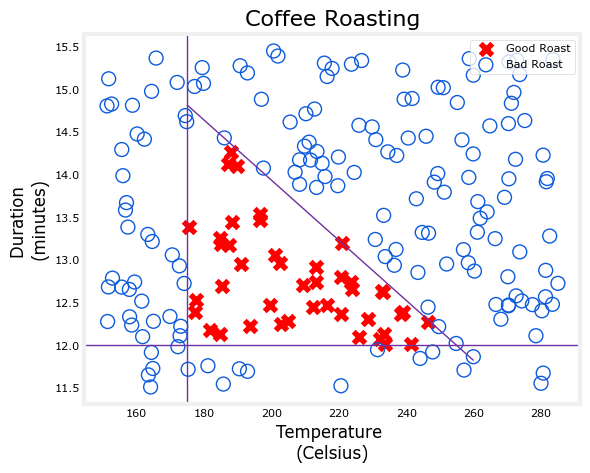

In [4]:
plt_roast(X,Y)

Noramalize Data


In [5]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [6]:
Xt = np.tile(Xn,(1000,1)) 
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


In [8]:
tf.random.set_seed(1234)  
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` provides a description of the network:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


In [9]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.23  0.57  0.72]
 [ 0.19 -0.91 -0.71]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[0.96]
 [0.7 ]
 [0.11]] 
b2(1,): [0.]


In [10]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)


Epoch 1/10
6250/6250 [==============================] - 5s 792us/step - loss: 0.2246
Epoch 2/10
6250/6250 [==============================] - 5s 760us/step - loss: 0.1450
Epoch 3/10
6250/6250 [==============================] - 6s 897us/step - loss: 0.1380
Epoch 4/10
6250/6250 [==============================] - 6s 924us/step - loss: 0.1351
Epoch 5/10
6250/6250 [==============================] - 5s 798us/step - loss: 0.1336
Epoch 6/10
6250/6250 [==============================] - 5s 751us/step - loss: 0.1326
Epoch 7/10
6250/6250 [==============================] - 5s 840us/step - loss: 0.1320
Epoch 8/10
6250/6250 [==============================] - 5s 759us/step - loss: 0.1314
Epoch 9/10
6250/6250 [==============================] - 5s 781us/step - loss: 0.1310
Epoch 10/10
6250/6250 [==============================] - 5s 793us/step - loss: 0.1307


#### Updated Weights
After fitting, the weights have been updated: 

In [11]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[  8.81   7.38  11.08]
 [  2.62 -17.15   8.06]] 
b1: [12.15 20.79 -1.4 ]
W2:
 [[  9.69]
 [  7.02]
 [-22.89]] 
b2: [-14.64]


In [24]:
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

### Predictions

In [25]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 16ms/step
predictions = 
 [[9.63e-01]
 [3.03e-08]]


In [26]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


In [27]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Layer Functions
Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.
> Note: In labs we typically number things starting at zero while the lectures may start with 1.

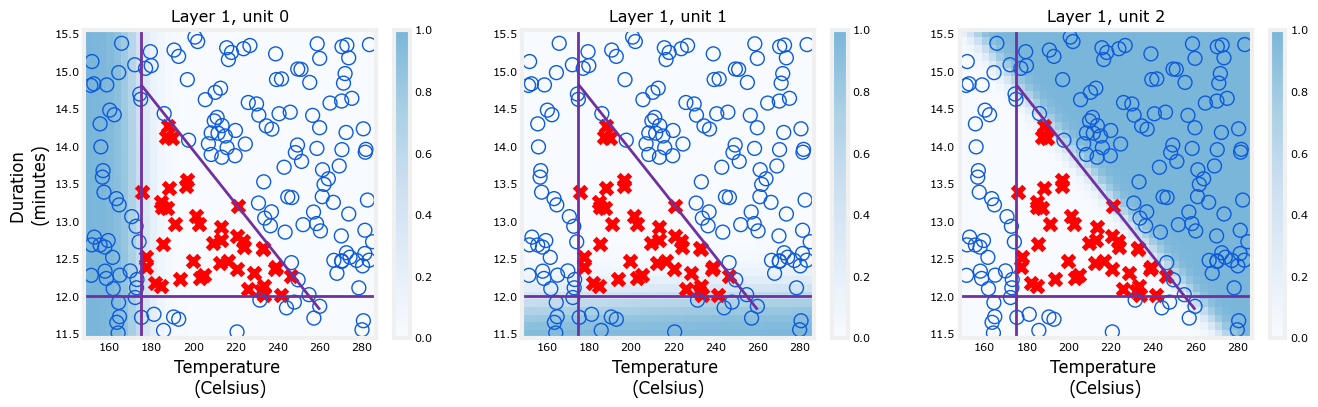

In [ ]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

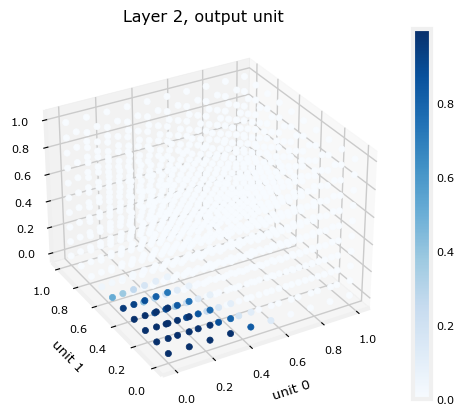

In [ ]:
plt_output_unit(W2,b2)

7/7 [==============================] - 0s 914us/step


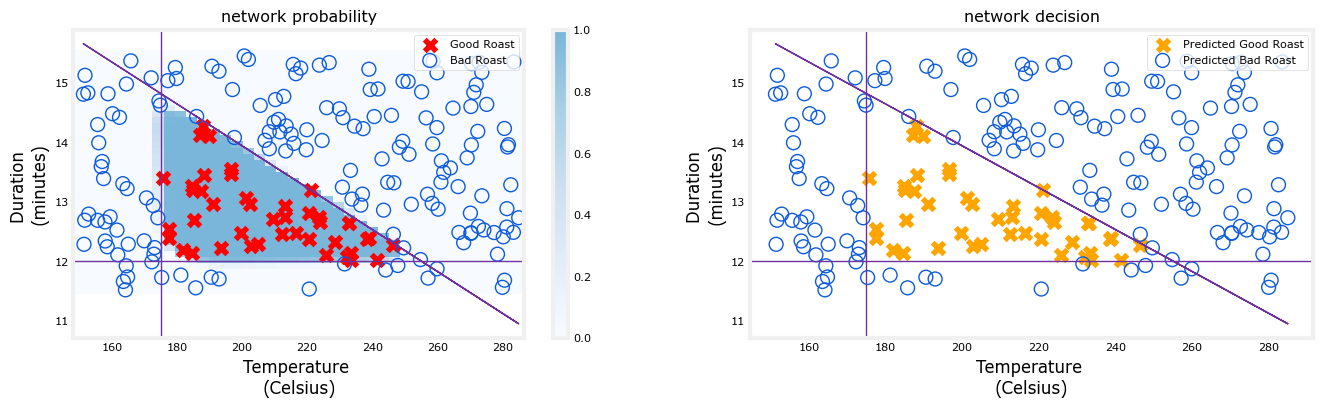

In [ ]:
netf= lambda x : model.predict(norm_l(x))
plt_network(X,Y,netf)